# Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import time
from sklearn.ensemble import RandomForestRegressor

# 1. Importing Data and Preprocessing

In [5]:
df = pd.read_pickle("C:/Users/zulla/OneDrive/Stevens/FE 800 Final Project/fe800_data.pkl 2/fe800_data.pkl")

In [6]:
#Making all columns numerical
columns = ['Price', 'Volume', 'Trades', 'Return', 'Age', 'TTM', 'Stock_Return',
       'Stock_Volume', 'ETF_Return', 'PV', 'YTM', 'Duration', 'DV01',
       'Convexity', 'RunningCoupon', 'ParSpread', 'CDSRealRecovery',
       'UpfrontBASpreadAverage', 'ConvBASpreadAverage', 'EstimatedNotional',
       'WklyNetNotional', 'DP', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
df = df.dropna()

In [5]:
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-03  86.821 -0.785507     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.573559    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.637707    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.115591     7.0  0.008142  5.060274  24.452055   
          2018-07-10  87.241 -0.519514    11.0 -0.024117  5.063014  24.449315   

                      Stock_Return  Stock_Volume  ETF_Return        PV  ...  \
cusip     trd_dt                                                        ...   
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849  ...   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749  ...   
          2018-07-06      0.002454      0.232636    0.007858  0.001668  ...   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931  ...   
          2018-07-10      0.010886      0.103056    0.002150 -0.001502  ...   

                      ConvBASpreadAverage  EstimatedNotional  WklyNetNotional  \
cusip     trd_dt                                                                
00206RBH4 2018-07-03             0.001092          5000000.0     1.173281e+09   
          2018-07-05             0.001299          5000000.0     1.152963e+09   
          2018-07-06             0.001073          5000000.0     1.152963e+09   
          2018-07-09             0.001243          5000000.0     1.152963e+09   
          2018-07-10             0.001245          5000000.0     1.152963e+09   

                            DP   AA    A  BBB   BB    B  CCC  
cusip     trd_dt                                              
00206RBH4 2018-07-03  0.142425  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-05  0.142928  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-06  0.143275  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-09  0.141889  0.0  0.0  1.0  0.0  0.0  0.0  
          2018-07-10  0.140366  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 28 columns]

In [7]:
#To see how the data is formatted
pred_df = predict_prices(df)
pred_df

,CUSIP,Trade_Date,Actual_Price,Predicted_Price
0,00206RBH4,2018-11-30,83.034500,83.132294
1,00206RBH4,2018-12-03,84.269000,83.849167
2,00206RBH4,2018-12-04,84.351400,83.877075
3,00206RBH4,2018-12-06,85.026769,84.659592
4,00206RBH4,2018-12-07,85.307869,84.632233
...,...,...,...,...
612115,98978VAL7,2023-06-26,93.630000,93.430222
612116,98978VAL7,2023-06-27,93.296000,93.032700
612117,98978VAL7,2023-06-28,93.682000,93.377243
612118,98978VAL7,2023-06-29,93.169000,92.023224


In [8]:
#Get list of all CUSIPs
unique_cusips = pred_df['CUSIP'].unique()

list_of_cusips = unique_cusips.tolist()

print(list_of_cusips)
print('There are: ', len(list_of_cusips), 'bonds being traded')

['00206RBH4', '00206RBK7', '00206RCP5', '00206RCQ3', '00206RCU4', '00206RDJ8', '00206RDK5', '00206RDQ2', '00206RDR0', '002824BF6', '002824BG4', '002824BH2', '00287YAM1', '00287YAR0', '00287YAS8', '00287YAV1', '00287YAW9', '00440EAW7', '00817YAF5', '00817YAZ1', '013716AU9', '02209SAM5', '02209SAR4', '02209SAV5', '023135AP1', '023135AQ9', '023135BC9', '023135BF2', '023135BJ4', '023135BM7', '025816BF5', '026874DF1', '026874DL8', '03040WAD7', '03040WAR6', '03073EAP0', '031162BZ2', '031162CD0', '031162CF5', '031162CQ1', '032654AN5', '03523TBF4', '03523TBT4', '035240AG5', '035240AL4', '035240AM2', '035240AN0', '035240AP5', '035242AN6', '03524BAF3', '037833AL4', '037833AT7', '037833BA7', '037833BH2', '037833BW9', '037833BX7', '037833CD0', '037833CH1', '037833CJ7', '037833CR9', '037833CX6', '037833DB3', '037833DD9', '037833DG2', '037833DK3', '038222AL9', '038222AM7', '046353AD0', '046353AG3', '046353AM0', '046353AN8', '049560AM7', '05565QDH8', '05565QDN5', '057224AZ0', '05723KAE0', '05723KAF7'

# 2. Functions

In [ ]:
#Baseline model?

## Predicting Prices Model 

In [8]:
def predict_prices(df, n_splits=12):
    predictions = []

    for cusip, cusip_df in df.groupby(level='cusip'):
        cusip_df = cusip_df.sort_index(level='trd_dt')
        X = cusip_df.drop(['Price'], axis=1)
        y = cusip_df['Price']

        tscv = TimeSeriesSplit(n_splits=n_splits)

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = xgb.XGBRegressor(objective='reg:squarederror')
            model.fit(X_train, y_train)

            predicted_prices = model.predict(X_test)
            test_dates = cusip_df.iloc[test_index].index.get_level_values('trd_dt')

            for date, predicted_price in zip(test_dates, predicted_prices):
                # Accessing y_test with multi-index (CUSIP, date)
                actual_price = y_test.loc[(cusip, date)] if (cusip, date) in y_test.index else np.nan

                if not np.isnan(actual_price):
                    predictions.append((cusip, date, actual_price, predicted_price))



    prediction_df = pd.DataFrame(predictions, columns=['CUSIP', 'Trade_Date', 'Actual_Price', 'Predicted_Price'])
    return prediction_df

In [28]:
def predict_prices(df, n_splits=12):
    prediction_data = []
    metrics_data = []
    total_train_r2, total_test_r2, total_test_mse, total_test_rmse, total_test_mae = 0, 0, 0, 0, 0
    cusip_count = 0

    for cusip, cusip_df in df.groupby(level='cusip'):
        cusip_df = cusip_df.sort_index(level='trd_dt')
        X = cusip_df.drop(['Price'], axis=1)
        y = cusip_df['Price']

        tscv = TimeSeriesSplit(n_splits=n_splits)

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model = xgb.XGBRegressor(objective='reg:squarederror')
            model.fit(X_train, y_train)

            # Making predictions
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            # Calculating metrics
            train_r2 = r2_score(y_train, train_predictions)
            test_r2 = r2_score(y_test, test_predictions)
            test_mse = mean_squared_error(y_test, test_predictions)
            test_rmse = np.sqrt(test_mse)
            test_mae = mean_absolute_error(y_test, test_predictions)

            # Summing metrics
            total_train_r2 += train_r2
            total_test_r2 += test_r2
            total_test_mse += test_mse
            total_test_rmse += test_rmse
            total_test_mae += test_mae

            # Storing metrics
            metrics_data.append({'CUSIP': cusip, 'Train R2': train_r2, 'Test R2': test_r2, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test MAE': test_mae})

            # Storing predictions and handling KeyError
            test_dates = cusip_df.iloc[test_index].index.get_level_values('trd_dt')
            for date, predicted_price in zip(test_dates, test_predictions):
                index_tuple = (cusip, date)
                if index_tuple in y_test.index:
                    actual_price = y_test.loc[index_tuple]
                    prediction_data.append({'CUSIP': cusip, 'Date': date, 'Actual Price': actual_price, 'Predicted Price': predicted_price})

        cusip_count += 1

    # Calculating averages
    avg_train_r2 = total_train_r2 / cusip_count
    avg_test_r2 = total_test_r2 / cusip_count
    avg_test_mse = total_test_mse / cusip_count
    avg_test_rmse = total_test_rmse / cusip_count
    avg_test_mae = total_test_mae / cusip_count

    # Convert lists to DataFrames
    predictions_df = pd.DataFrame(prediction_data)
    metrics_df = pd.DataFrame(metrics_data)

    # Return predictions, metrics, and average metrics
    return predictions_df, metrics_df, (avg_train_r2, avg_test_r2, avg_test_mse, avg_test_rmse, avg_test_mae)

# Example usage:
# predictions_df, metrics_df, avg_metrics = predict_prices(df)
# avg_train_r2, avg_test_r2, avg_test_mse, avg_test_rmse, avg_test_mae = avg_metrics


In [37]:
def predict_prices(df, n_splits=12):
    prediction_data_rf = []
    prediction_data_xgb = []
    metrics_data = []

    sum_rf_train_r2, sum_rf_test_r2, sum_rf_test_mse, sum_rf_test_rmse, sum_rf_test_mae = 0, 0, 0, 0, 0
    sum_xgb_train_r2, sum_xgb_test_r2, sum_xgb_test_mse, sum_xgb_test_rmse, sum_xgb_test_mae = 0, 0, 0, 0, 0
    cusip_count = 0

    for cusip, cusip_df in df.groupby(level='cusip'):
        cusip_df = cusip_df.sort_index(level='trd_dt')
        X = cusip_df.drop(['Price'], axis=1)
        y = cusip_df['Price']

        tscv = TimeSeriesSplit(n_splits=n_splits)

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train with Random Forest
            rf_model = RandomForestRegressor()
            rf_model.fit(X_train, y_train)

            # Train with XGBoost
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
            xgb_model.fit(X_train, y_train)

            # Making predictions with both models
            rf_test_predictions = rf_model.predict(X_test)
            xgb_test_predictions = xgb_model.predict(X_test)

            # Storing predictions and handling KeyError for Random Forest
            test_dates = cusip_df.iloc[test_index].index.get_level_values('trd_dt')
            for date, predicted_price in zip(test_dates, rf_test_predictions):
                index_tuple = (cusip, date)
                if index_tuple in y_test.index:
                    actual_price = y_test.loc[index_tuple]
                    prediction_data_rf.append({'CUSIP': cusip, 'Date': date, 'Actual Price': actual_price, 'Predicted Price (RF)': predicted_price})

            # Storing predictions and handling KeyError for XGBoost
            for date, predicted_price in zip(test_dates, xgb_test_predictions):
                index_tuple = (cusip, date)
                if index_tuple in y_test.index:
                    actual_price = y_test.loc[index_tuple]
                    prediction_data_xgb.append({'CUSIP': cusip, 'Date': date, 'Actual Price': actual_price, 'Predicted Price (XGB)': predicted_price})

            # Calculating metrics for Random Forest
            rf_train_r2 = r2_score(y_train, rf_model.predict(X_train))
            rf_test_r2 = r2_score(y_test, rf_test_predictions)
            rf_test_mse = mean_squared_error(y_test, rf_test_predictions)
            rf_test_rmse = np.sqrt(rf_test_mse)
            rf_test_mae = mean_absolute_error(y_test, rf_test_predictions)

            # Summing metrics for Random Forest
            sum_rf_train_r2 += rf_train_r2
            sum_rf_test_r2 += rf_test_r2
            sum_rf_test_mse += rf_test_mse
            sum_rf_test_rmse += rf_test_rmse
            sum_rf_test_mae += rf_test_mae

            # Calculating metrics for XGBoost
            xgb_train_r2 = r2_score(y_train, xgb_model.predict(X_train))
            xgb_test_r2 = r2_score(y_test, xgb_test_predictions)
            xgb_test_mse = mean_squared_error(y_test, xgb_test_predictions)
            xgb_test_rmse = np.sqrt(xgb_test_mse)
            xgb_test_mae = mean_absolute_error(y_test, xgb_test_predictions)

            # Summing metrics for XGBoost
            sum_xgb_train_r2 += xgb_train_r2
            sum_xgb_test_r2 += xgb_test_r2
            sum_xgb_test_mse += xgb_test_mse
            sum_xgb_test_rmse += xgb_test_rmse
            sum_xgb_test_mae += xgb_test_mae

            # Storing metrics
            metrics_data.append({
                'CUSIP': cusip,
                'RF Train R2': rf_train_r2, 'RF Test R2': rf_test_r2, 'RF Test MSE': rf_test_mse, 'RF Test RMSE': rf_test_rmse, 'RF Test MAE': rf_test_mae,
                'XGB Train R2': xgb_train_r2, 'XGB Test R2': xgb_test_r2, 'XGB Test MSE': xgb_test_mse, 'XGB Test RMSE': xgb_test_rmse, 'XGB Test MAE': xgb_test_mae
            })

        cusip_count += 1

    # Calculating averages for both models
    avg_metrics_rf = (sum_rf_train_r2 / cusip_count, sum_rf_test_r2 / cusip_count, sum_rf_test_mse / cusip_count, sum_rf_test_rmse / cusip_count, sum_rf_test_mae / cusip_count)
    avg_metrics_xgb = (sum_xgb_train_r2 / cusip_count, sum_xgb_test_r2 / cusip_count, sum_xgb_test_mse / cusip_count, sum_xgb_test_rmse / cusip_count, sum_xgb_test_mae / cusip_count)

    # Convert lists to DataFrames
    predictions_df_rf = pd.DataFrame(prediction_data_rf)
    predictions_df_xgb = pd.DataFrame(prediction_data_xgb)
    metrics_df = pd.DataFrame(metrics_data)

    return predictions_df_rf, predictions_df_xgb, metrics_df, avg_metrics_rf, avg_metrics_xgb

# Example usage:
# predictions_df_rf, predictions_df_xgb, metrics_df, avg_metrics_rf, avg_metrics_xgb = predict_prices(df)


## Transaction Cost Function - Interactive Brokers

In [9]:
def calculate_transaction_cost(order_value):
    cost = order_value * 0.0010  # 10 bps
    cost = max(1, cost)  # Minimum of $1
    cost = min(250, cost)  # Maximum of $250
    return cost

## Backtesting Strategy Function

In [10]:
#Can change the threshold, currently at a 1% differnce in price
def backtest_strategy(predicted_prices_df, starting_portfolio=100000, trade_threshold=0.01):
    portfolio_value = starting_portfolio
    portfolio_values = [portfolio_value]
    trade_dates = []
    trade_actions = {}
    cusip_profit = {}
    trade_details = []
    wins = 0
    losses = 0
    max_drawdown = 0
    peak_portfolio_value = starting_portfolio

    for index, row in predicted_prices_df.iterrows():
        cusip, trade_date, actual_price, predicted_price = row['CUSIP'], row['Trade_Date'], row['Actual_Price'], row['Predicted_Price']
        trade_dates.append(trade_date)
        previous_portfolio_value = portfolio_value

        # Implement your trading logic here
        percentage_diff = (predicted_price - actual_price) / actual_price
        if abs(percentage_diff) >= trade_threshold:
            
            #I want to fix trade size, maybe just equally divide by # of bonds so 610?
            trade_size = portfolio_value / 610
            transaction_cost = calculate_transaction_cost(trade_size)
            action = ''

            if percentage_diff > 0:
                action = 'Buy'
                portfolio_value -= trade_size + transaction_cost
            elif percentage_diff < 0:
                action = 'Sell'
                portfolio_value += trade_size - transaction_cost

            # Record wins, losses, and actions
            if portfolio_value > previous_portfolio_value:
                wins += 1
            elif portfolio_value < previous_portfolio_value:
                losses += 1

            if cusip not in trade_actions:
                trade_actions[cusip] = []
            trade_actions[cusip].append((trade_date, action, actual_price))

            # Record trade details
            profit_loss = portfolio_value - previous_portfolio_value
            trade_details.append({'CUSIP': cusip, 'Date': trade_date, 'Profit': profit_loss})

        portfolio_values.append(portfolio_value)

        # Update peak portfolio value for drawdown calculation
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)
        drawdown = (peak_portfolio_value - portfolio_value) / peak_portfolio_value
        max_drawdown = max(max_drawdown, drawdown)

        # Accumulate profit/loss per CUSIP
        if cusip not in cusip_profit:
            cusip_profit[cusip] = 0
        cusip_profit[cusip] += portfolio_value - previous_portfolio_value

    # Calculate win percentage
    total_trades = wins + losses
    win_percentage = (wins / total_trades) * 100 if total_trades > 0 else 0

    # Sort CUSIPs and trades for analysis
    most_profitable_cusips = sorted(cusip_profit.items(), key=lambda x: x[1], reverse=True)
    best_trades = sorted(trade_details, key=lambda x: x['Profit'], reverse=True)

    # Ensure trade_dates and portfolio_values are synchronized
    if len(trade_dates) + 1 == len(portfolio_values):
        trade_dates.insert(0, predicted_prices_df.iloc[0]['Trade_Date'])

    return trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades


#trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.01)

## Plotting CUSIP Level Trade Signals

In [11]:
def plot_cusip_trades(predicted_prices_df, trade_actions, cusip_to_plot, start_date=None, end_date=None):
    # Convert start_date and end_date to Timestamp if they are not None
    if start_date:
        start_date = pd.to_datetime(start_date)
    if end_date:
        end_date = pd.to_datetime(end_date)

    # Filter the DataFrame for the specific CUSIP
    cusip_data = predicted_prices_df[predicted_prices_df['CUSIP'] == cusip_to_plot]

    # If start_date and/or end_date are specified, filter the data accordingly
    if start_date:
        cusip_data = cusip_data[cusip_data['Trade_Date'] >= start_date]
    if end_date:
        cusip_data = cusip_data[cusip_data['Trade_Date'] <= end_date]

    # Extract dates and prices
    dates = cusip_data['Trade_Date']
    prices = cusip_data['Actual_Price']

    # Prepare buy and sell points within the specified time frame
    buy_dates, buy_prices, sell_dates, sell_prices = [], [], [], []
    for date, action, price in trade_actions.get(cusip_to_plot, []):
        if start_date and date < start_date:
            continue
        if end_date and date > end_date:
            continue

        if action == 'Buy':
            buy_dates.append(date)
            buy_prices.append(price)
        elif action == 'Sell':
            sell_dates.append(date)
            sell_prices.append(price)

    plt.figure(figsize=(12, 6))
    plt.plot(dates, prices, label='Price', color='blue', alpha=0.6)
    plt.scatter(buy_dates, buy_prices, color='green', marker='^', label='Buy')
    plt.scatter(sell_dates, sell_prices, color='red', marker='v', label='Sell')
    plt.title(f'Trade Actions for CUSIP {cusip_to_plot} from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Plotting Cumulative Returns

In [10]:
def plot_cumulative_returns(trade_dates, portfolio_values, cusip_to_plot, trade_actions, start_date=None, end_date=None):
    # Convert start_date and end_date to Timestamp if they are not None
    if start_date:
        start_date = pd.to_datetime(start_date)
    if end_date:
        end_date = pd.to_datetime(end_date)

    # Filter for the specific CUSIP
    filtered_trade_dates = []
    filtered_portfolio_values = []
    initial_value = None

    for date, action, _ in trade_actions.get(cusip_to_plot, []):
        if start_date and date < start_date:
            continue
        if end_date and date > end_date:
            continue

        if date in trade_dates:
            index = trade_dates.index(date)
            filtered_trade_dates.append(date)
            filtered_portfolio_values.append(portfolio_values[index])

            if initial_value is None:
                initial_value = portfolio_values[index]

    # Calculate cumulative returns if we have data
    if initial_value is not None and filtered_portfolio_values:
        cumulative_returns = [(pv / initial_value - 1) * 100 for pv in filtered_portfolio_values]

        plt.figure(figsize=(12, 6))
        plt.plot(filtered_trade_dates, cumulative_returns, color='blue', linestyle='-', marker='o')
        plt.title(f'Cumulative Returns for CUSIP {cusip_to_plot} from {start_date} to {end_date}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns (%)')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print(f"No trade data available for CUSIP {cusip_to_plot} in the specified time frame.")

In [16]:
def plot_cumulative_returns(trade_dates, portfolio_values, risk_free_rate=0.04):
    # Calculate daily returns
    daily_returns = [((portfolio_values[i] / portfolio_values[i - 1]) - 1) for i in range(1, len(portfolio_values))]

    # Annualized Returns
    num_years = (trade_dates[-1] - trade_dates[0]).days / 365.25
    annualized_return = (portfolio_values[-1] / portfolio_values[0]) ** (1 / num_years) - 1

    # Annual Standard Deviation
    annual_std_dev = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annual_std_dev

    # Plotting the cumulative returns
    cumulative_returns = [(pv / portfolio_values[0] - 1) * 100 for pv in portfolio_values]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, cumulative_returns, color='blue', linestyle='-', marker='o')
    plt.title(f'Cumulative Returns (Annualized Return: {annualized_return:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}, Std Dev: {annual_std_dev:.2%})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (%)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Usage:
# plot_cumulative_returns(trade_dates, portfolio_values)


## Plotting Cumulative Returns with Drawdown

In [13]:
def plot_cumulative_returns_with_drawdown(trade_dates, portfolio_values, max_drawdown):
    initial_value = portfolio_values[0]
    cumulative_returns = [(pv / initial_value - 1) * 100 for pv in portfolio_values]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, cumulative_returns, color='blue', linestyle='-', marker='o', label='Cumulative Returns')

    # Highlight maximum drawdown
    drawdown_percent = max_drawdown * 100
    plt.axhline(y=-drawdown_percent, color='red', linestyle='--', label=f'Max Drawdown: {drawdown_percent:.2f}%')

    plt.title('Cumulative Returns with Drawdown')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

## Performance Summary

In [14]:
def print_performance_summary(trade_dates, portfolio_values, wins, losses, max_drawdown):
    # Calculate PnL for each trade
    pnl = np.diff(portfolio_values)

    # Calculate standard deviation of PnL
    pnl_std_dev = np.std(pnl)

    # Calculate total trades, win percentage, and ending value
    total_trades = wins + losses
    win_percentage = (wins / total_trades) * 100 if total_trades > 0 else 0
    starting_value = portfolio_values[0]
    ending_value = portfolio_values[-1]

    # Print the summary table
    print("Performance Summary:")
    print(f"{'Metric':<30}{'Value':<15}")
    print("-" * 45)
    #print(f"{'Starting Portfolio Value':<30}${starting_value:<15.2f}")
    #print(f"{'Ending Portfolio Value':<30}${ending_value:<15.2f}")
    print(f"{'Total Trades':<30}{total_trades:<15}")
    print(f"{'Winning Trades':<30}{wins:<15}")
    print(f"{'Losing Trades':<30}{losses:<15}")
    print(f"{'Win Percentage':<30}{win_percentage:<15.2f}%")
    #print(f"{'Standard Deviation of PnL':<30}${pnl_std_dev:<15.2f}")
    #print(f"{'Maximum Drawdown':<30}{max_drawdown * 100:<15.2f}%")

# 3. Predictions on the Dataset

In [38]:
#This first uses random forest then XGboost after
predictions_df_rf, predictions_df_xgb, metrics_df, avg_metrics_rf, avg_metrics_xgb = predict_prices(df)

In [39]:
avg_metrics_rf

(11.988255969498725,
 -0.7258509272150285,
 115.93499703676383,
 28.582856560558557,
 22.869519745867365)

In [40]:
avg_metrics_xgb

(11.999995687395401,
 -0.2045173065962573,
 118.44752635270842,
 28.5451371031081,
 22.60749124063227)

In [41]:
metrics_df

,CUSIP,RF Train R2,RF Test R2,RF Test MSE,RF Test RMSE,RF Test MAE,XGB Train R2,XGB Test R2,XGB Test MSE,XGB Test RMSE,XGB Test MAE
0,00206RBH4,0.997121,-0.103207,7.617834,2.760042,2.178464,1.000000,0.380192,4.279881,2.068787,1.404189
1,00206RBH4,0.998313,-1.489782,38.889917,6.236178,4.955816,1.000000,-1.290853,35.782676,5.981862,4.659569
2,00206RBH4,0.999623,-1.095123,6.439690,2.537655,2.278864,1.000000,0.584201,1.278025,1.130498,0.904588
3,00206RBH4,0.999767,0.931777,2.256073,1.502023,1.091008,1.000000,0.957259,1.413389,1.188860,0.831440
4,00206RBH4,0.999822,-0.506995,8.622603,2.936427,2.253290,1.000000,-0.278218,7.313609,2.704368,1.969315
...,...,...,...,...,...,...,...,...,...,...,...
7315,98978VAL7,0.999811,0.132515,1.536425,1.239526,1.061831,1.000000,0.272662,1.288207,1.134992,0.970467
7316,98978VAL7,0.999770,0.919582,0.604716,0.777635,0.603097,1.000000,0.736974,1.977863,1.406365,1.160569
7317,98978VAL7,0.999700,-0.879012,4.325001,2.079664,1.841692,0.999999,-0.042988,2.400690,1.549416,1.365106
7318,98978VAL7,0.999678,0.313423,2.336117,1.528436,1.395696,0.999999,0.486190,1.748270,1.322221,1.144633


In [46]:
outliers = metrics_df[metrics_df['RF Train R2'] < 0.99]
outliers

,CUSIP,RF Train R2,RF Test R2,RF Test MSE,RF Test RMSE,RF Test MAE,XGB Train R2,XGB Test R2,XGB Test MSE,XGB Test RMSE,XGB Test MAE
84,00206RDQ2,0.989969,-0.586804,6.426888,2.535131,2.160325,1.000000,-0.647018,6.670768,2.582783,2.134576
108,002824BF6,0.982883,0.045558,3.803246,1.950191,1.525258,0.999999,0.400984,2.386949,1.544975,1.263320
240,013716AU9,0.978533,-2.633914,29.715551,5.451197,4.688795,1.000000,-2.418075,27.950574,5.286830,4.483194
420,03073EAP0,0.891716,0.195906,1.901706,1.379024,0.988761,1.000000,-2.829474,9.056813,3.009454,1.423311
421,03073EAP0,0.957166,-0.937224,9.580731,3.095276,2.387351,1.000000,-0.719906,8.505963,2.916498,2.049799
...,...,...,...,...,...,...,...,...,...,...,...
7080,94106LBE8,0.977185,-2.355732,9.974004,3.158165,2.721976,0.999999,-2.623043,10.768515,3.281542,2.858654
7200,95000U2A0,0.983367,0.055030,3.668509,1.915335,1.523000,0.999999,0.169757,3.223123,1.795306,1.475971
7212,95040QAD6,0.985945,0.113418,3.011489,1.735364,1.351298,1.000000,0.074338,3.144232,1.773198,1.424113
7224,961214DK6,0.977138,-2.695992,10.831679,3.291152,2.909192,0.999999,-2.462542,10.147519,3.185517,2.795033


In [29]:
#Predicting the prices function # 2, believe can get rid of 1 and # 3 is above
#The one above usese random forest as well

start_time = time.time()

#predicted_prices_df = predict_prices(df)

#predictions_df, metrics_df = predict_prices(df)

predictions_df, metrics_df, avg_metrics = predict_prices(df)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {minutes} minutes and {seconds} seconds")

Execution time: 13 minutes and 48 seconds


In [30]:
metrics_df

,CUSIP,Train R2,Test R2,Test MSE,Test RMSE,Test MAE
0,00206RBH4,1.000000,0.380192,4.279881,2.068787,1.404189
1,00206RBH4,1.000000,-1.290853,35.782676,5.981862,4.659569
2,00206RBH4,1.000000,0.584201,1.278025,1.130498,0.904588
3,00206RBH4,1.000000,0.957259,1.413389,1.188860,0.831440
4,00206RBH4,1.000000,-0.278218,7.313609,2.704368,1.969315
...,...,...,...,...,...,...
7315,98978VAL7,1.000000,0.272662,1.288207,1.134992,0.970467
7316,98978VAL7,1.000000,0.736974,1.977863,1.406365,1.160569
7317,98978VAL7,0.999999,-0.042988,2.400690,1.549416,1.365106
7318,98978VAL7,0.999999,0.486190,1.748270,1.322221,1.144633


In [31]:
avg_train_r2, avg_test_r2, avg_test_mse, avg_test_rmse, avg_test_mae = avg_metrics
avg_metrics

(11.999995687395401,
 -0.2045173065962573,
 118.44752635270842,
 28.5451371031081,
 22.60749124063227)

# 4. Results and Examples for 1% Threshold

In [17]:
# Backtest the strategy
start_time = time.time()

trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.01)

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate the execution time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Execution time: {minutes} minutes and {seconds} seconds")

Execution time: 0 minutes and 24 seconds


## CUSIP 00206RBH4 for 2022

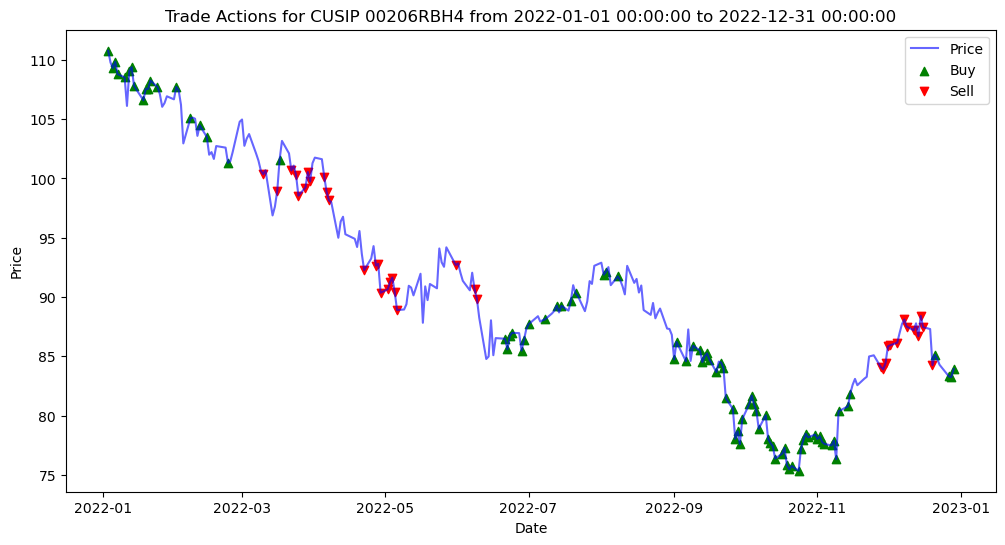

In [18]:
#Cusip Trade Signals
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

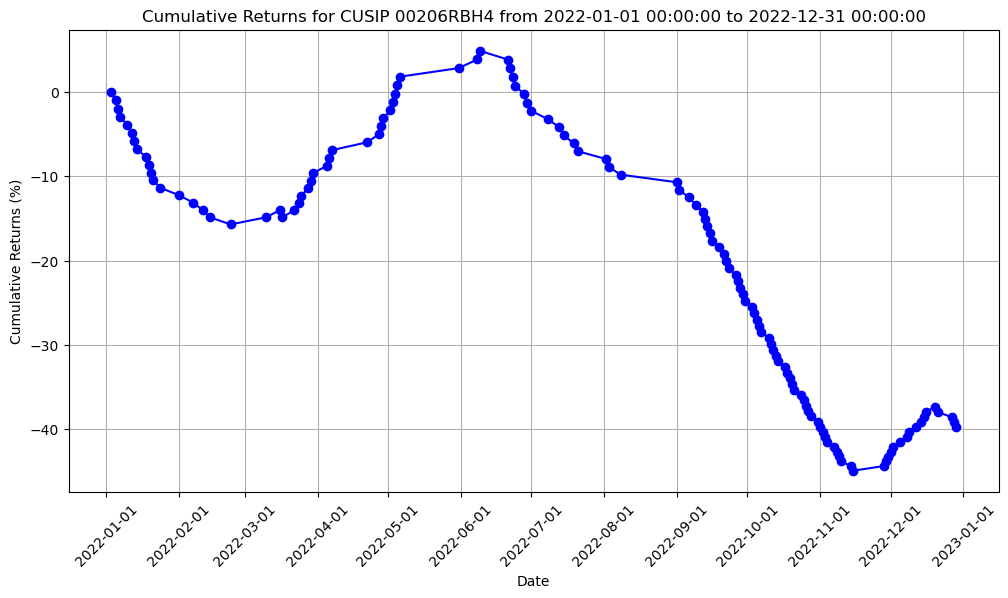

In [56]:
#Cusip Cumulative Returns
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

## CUSIP 00206RBK7 from Jan - June 2023

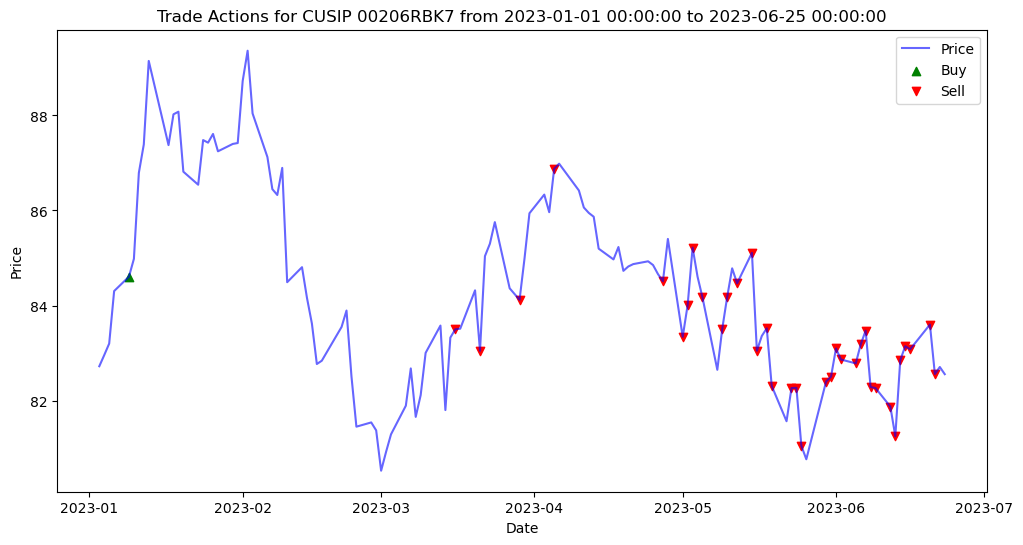

In [19]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

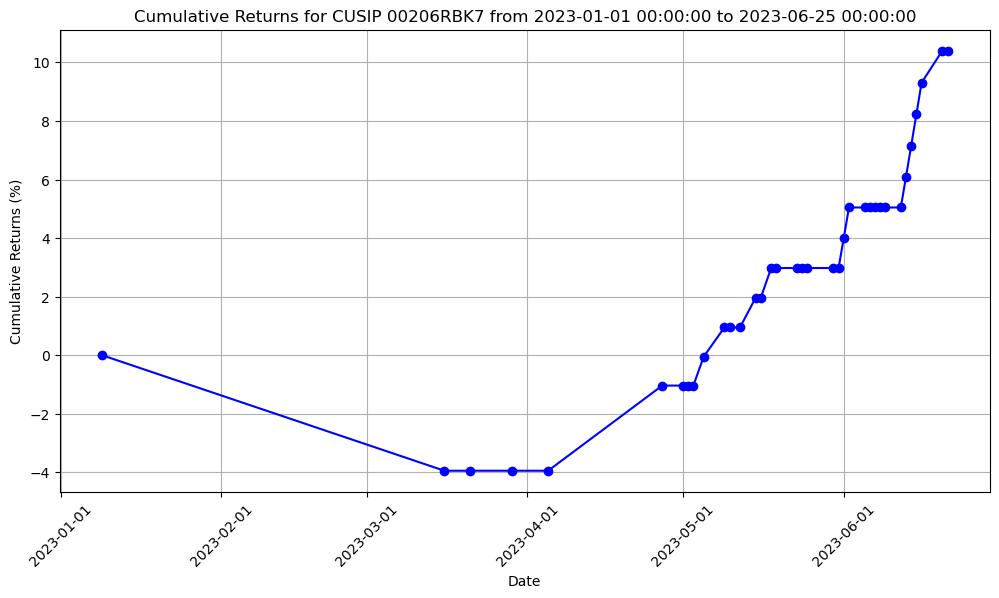

In [58]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBK7', trade_actions, '2023-01-01', '2023-06-25')

In [48]:
print_performance_summary(trade_dates, portfolio_values, wins, losses, max_drawdown)

Performance Summary:
Metric                        Value          
---------------------------------------------
Total Trades                  152968         
Winning Trades                109556         
Losing Trades                 43412          
Win Percentage                71.62          %


# 5. Results and Examples for 3% Threshold

In [61]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.03)

## CUSIP 00206RBH4 for 2022

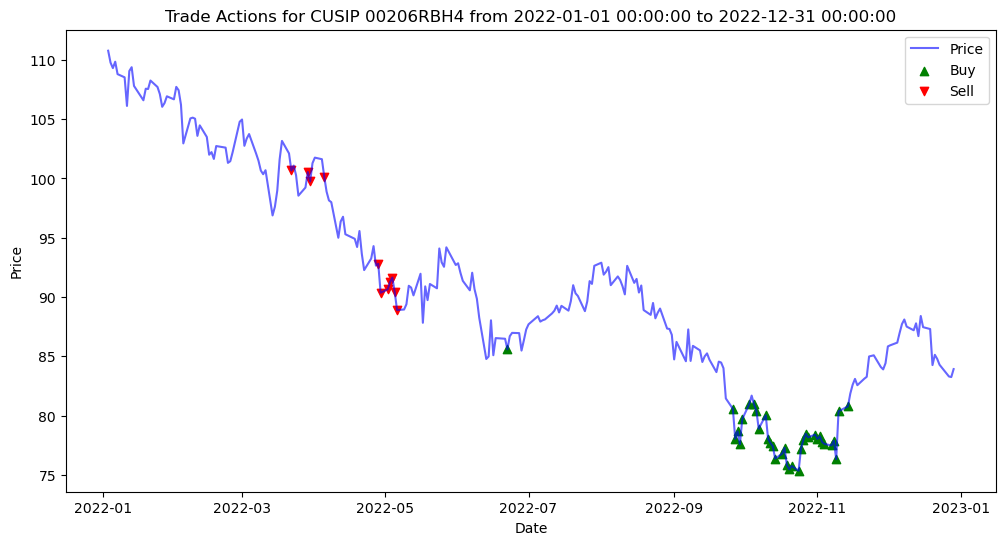

In [28]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

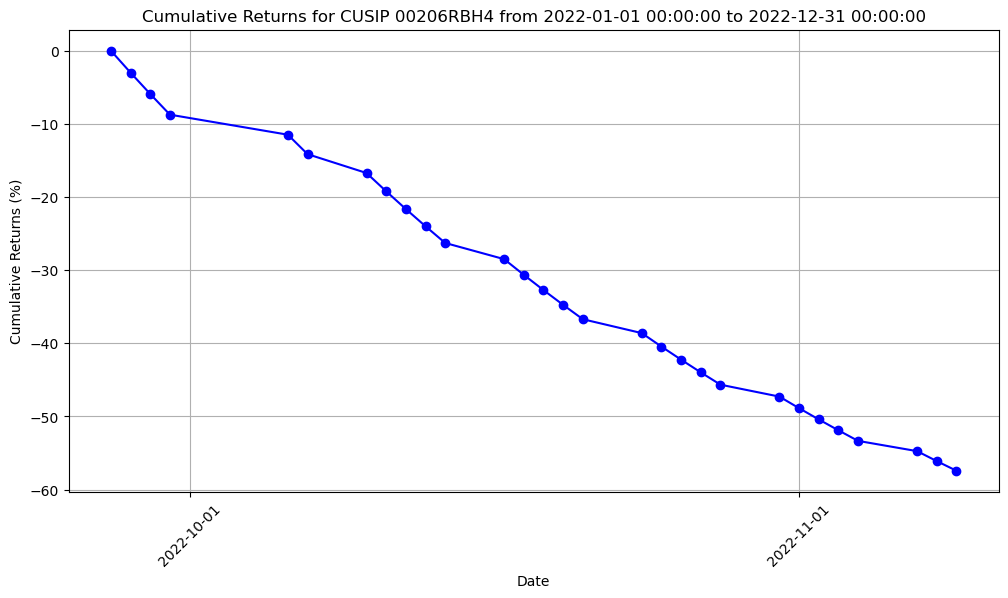

In [63]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

## CUSIP 00206RBK7 from Jan - June 2023

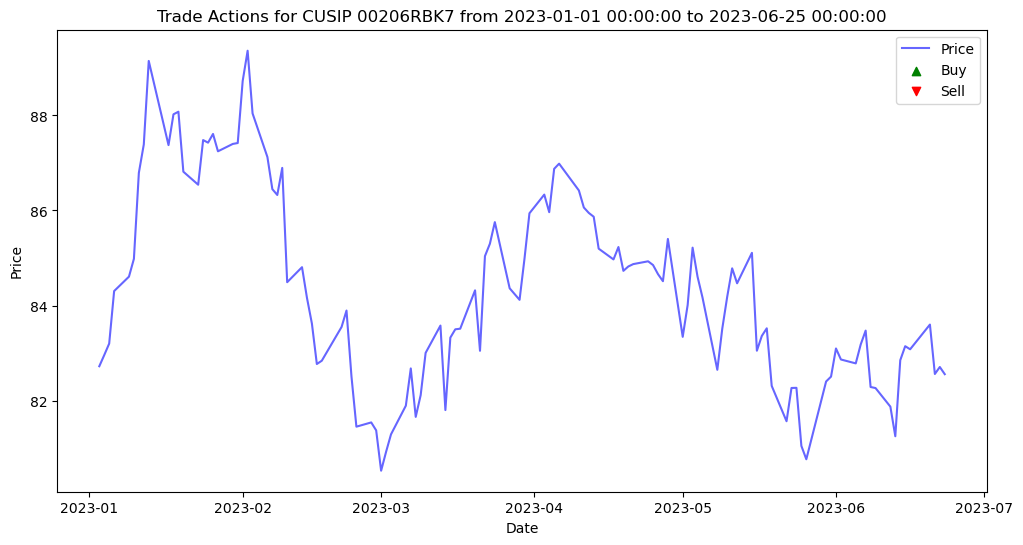

In [64]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

In [29]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBK7', trade_actions, '2023-01-01', '2023-06-25')

No trade data available for CUSIP 00206RBK7 in the specified time frame.


# Results and Examples for 5% Threshold

In [30]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown = backtest_strategy(predicted_prices_df, trade_threshold=0.05)

# CUSIP 00206RBH4 for 2022

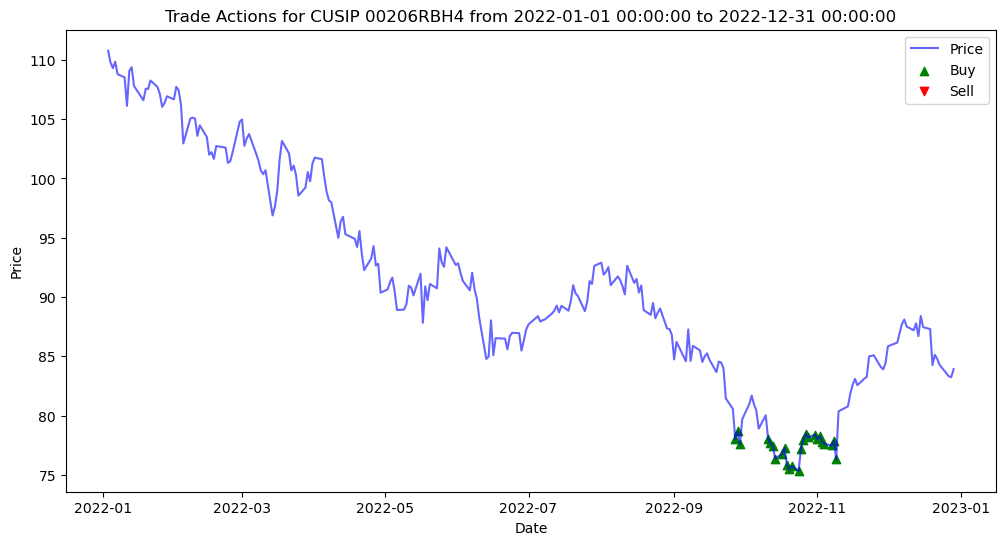

In [31]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

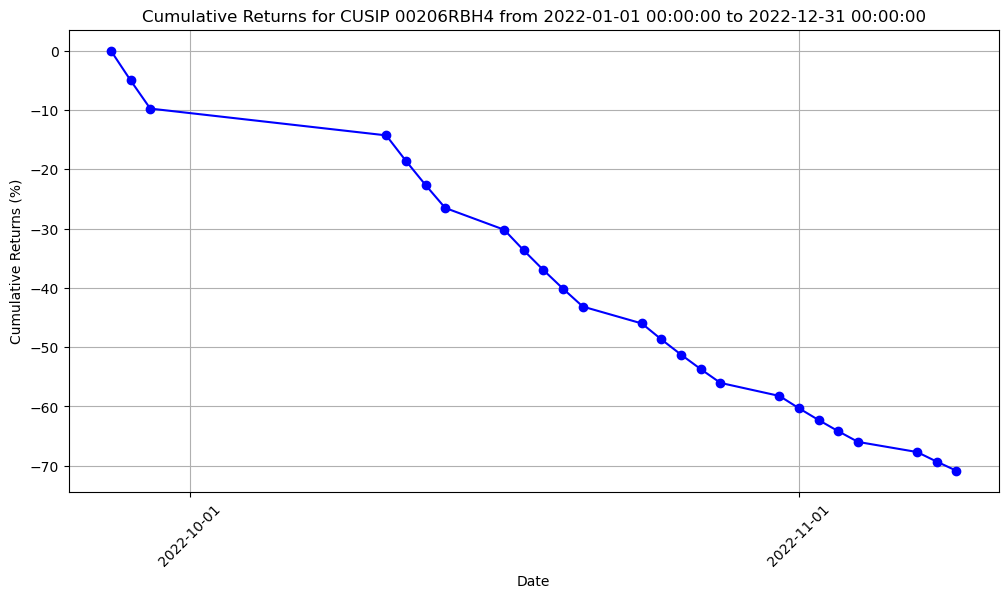

In [32]:
plot_cumulative_returns(trade_dates, portfolio_values, '00206RBH4', trade_actions, '2022-01-01', '2022-12-31')

# CUSIP 00206RBK7 from Jan - June 2023

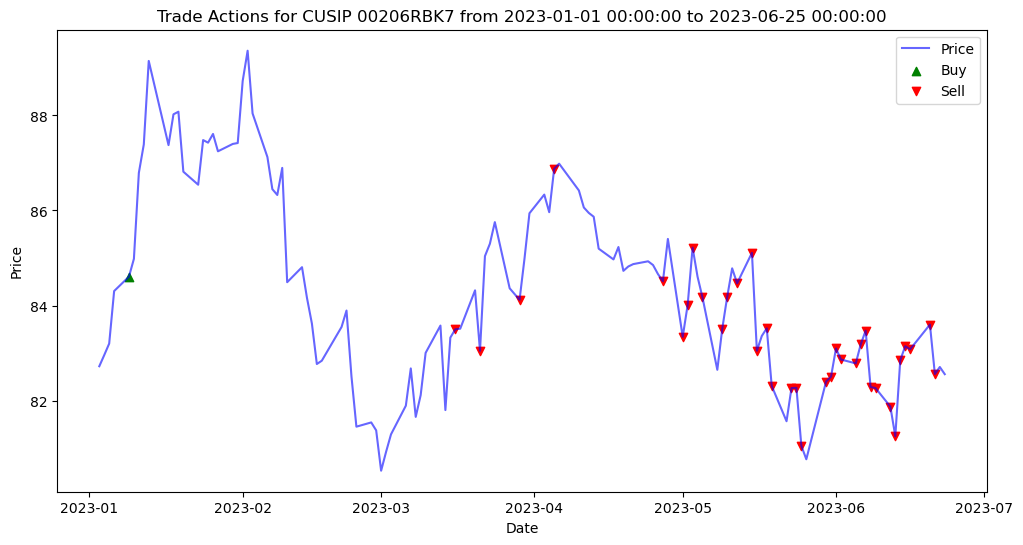

In [21]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBK7', start_date='2023-01-01', end_date='2023-06-25')

# 6. Results and Examples for 0.5% Threshold

In [65]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.005)

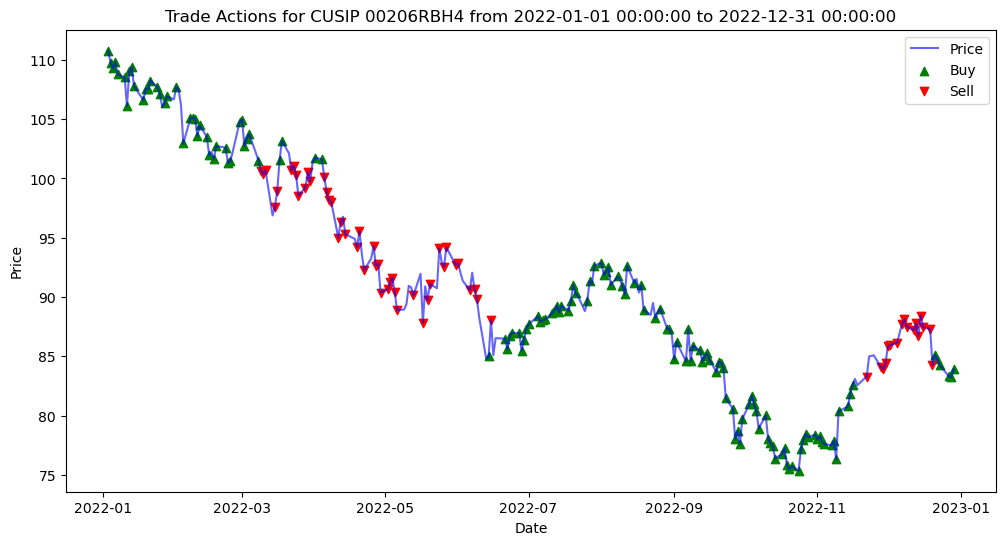

In [66]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RBH4', start_date='2022-01-01', end_date='2022-12-31')

# 2 % and search of a good visualization

In [47]:
trade_dates, portfolio_values, trade_actions, wins, losses, win_percentage, max_drawdown, most_profitable_cusips, best_trades = backtest_strategy(predicted_prices_df, trade_threshold=0.02)

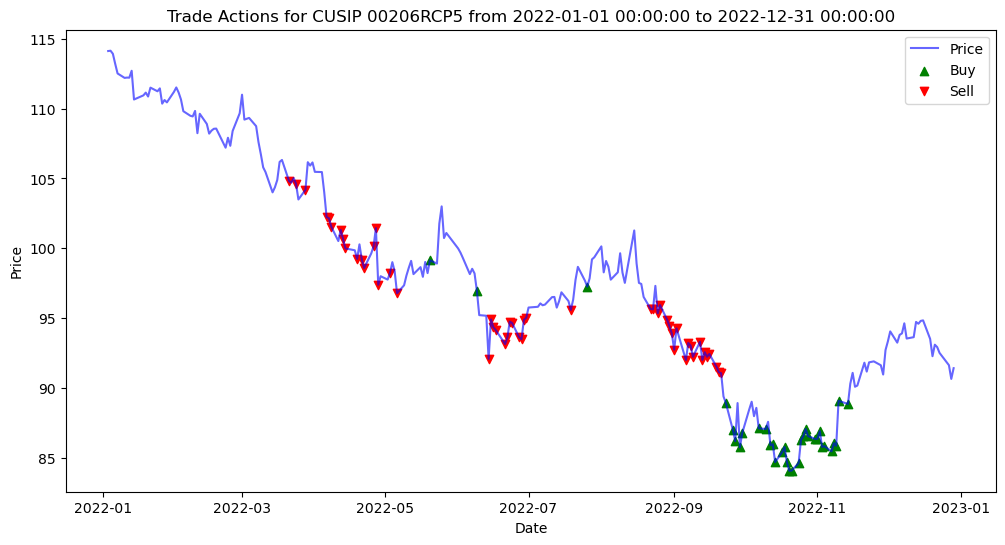

In [27]:
plot_cusip_trades(predicted_prices_df, trade_actions, '00206RCP5', start_date='2022-01-01', end_date='2022-12-31')

# 7. Most Profitable CUSIPs and Trades

In [23]:
print("Most Profitable CUSIPs:")
for cusip, profit in most_profitable_cusips[:10]:  # Adjust the number to view as needed
    print(f"CUSIP: {cusip}, Profit: {profit}")

Most Profitable CUSIPs:
CUSIP: 98978VAL7, Profit: 5.76949312401008e+50
CUSIP: 96950FAF1, Profit: 2.1591028935127702e+50
CUSIP: 96949LAD7, Profit: 1.753052134242991e+50
CUSIP: 98978VAH6, Profit: 1.0520732212707739e+50
CUSIP: 961214DW0, Profit: 9.109036950468864e+49
CUSIP: 96949LAC9, Profit: 4.812799230856006e+49
CUSIP: 96949LAE5, Profit: 4.538828795361526e+49
CUSIP: 95000U2A0, Profit: 4.465973164258402e+49
CUSIP: 95040QAD6, Profit: 4.0624677000502874e+49
CUSIP: 94974BGL8, Profit: 1.8938570525885674e+49


In [24]:
# Print the best trades
print("Best Trades:")
for trade in best_trades[:10]:  # Adjust the number to view as needed
    print(f"Date: {trade['Date']}, CUSIP: {trade['CUSIP']}, Profit: {trade['Profit']}")

Best Trades:
Date: 2023-03-14 00:00:00, CUSIP: 98978VAL7, Profit: 2.4436050429961374e+48
Date: 2023-03-13 00:00:00, CUSIP: 98978VAL7, Profit: 2.43960568940683e+48
Date: 2023-06-29 00:00:00, CUSIP: 98978VAL7, Profit: 2.4395860205076415e+48
Date: 2023-03-10 00:00:00, CUSIP: 98978VAL7, Profit: 2.4356128814045603e+48
Date: 2023-06-21 00:00:00, CUSIP: 98978VAL7, Profit: 2.4355932446966155e+48
Date: 2023-03-09 00:00:00, CUSIP: 98978VAL7, Profit: 2.4316266082762494e+48
Date: 2023-03-08 00:00:00, CUSIP: 98978VAL7, Profit: 2.4276468593265966e+48
Date: 2023-03-07 00:00:00, CUSIP: 98978VAL7, Profit: 2.423673623877581e+48
Date: 2023-03-06 00:00:00, CUSIP: 98978VAL7, Profit: 2.4197068912689603e+48
Date: 2023-03-03 00:00:00, CUSIP: 98978VAL7, Profit: 2.4157466508576058e+48


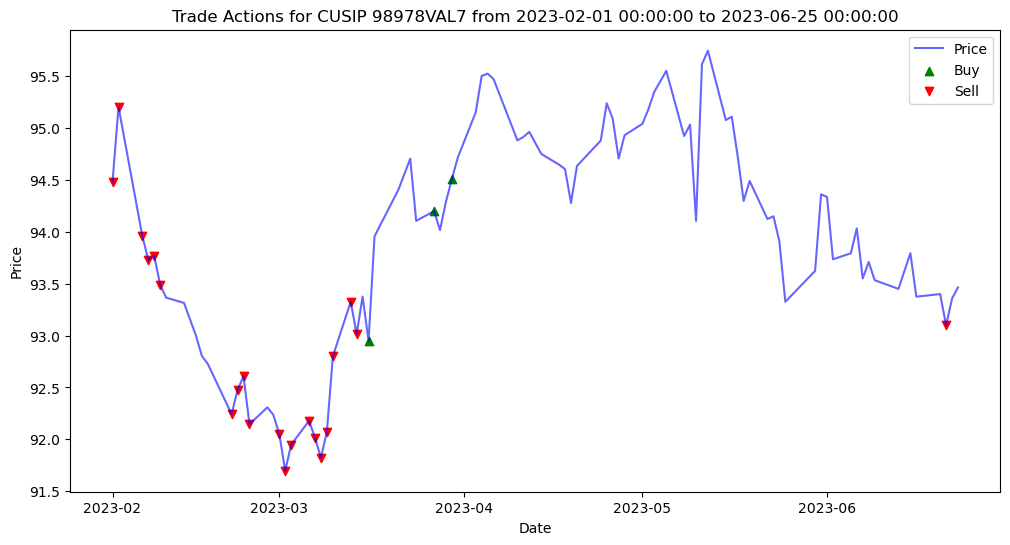

In [25]:
plot_cusip_trades(predicted_prices_df, trade_actions, '98978VAL7', start_date='2023-02-01', end_date='2023-06-25')

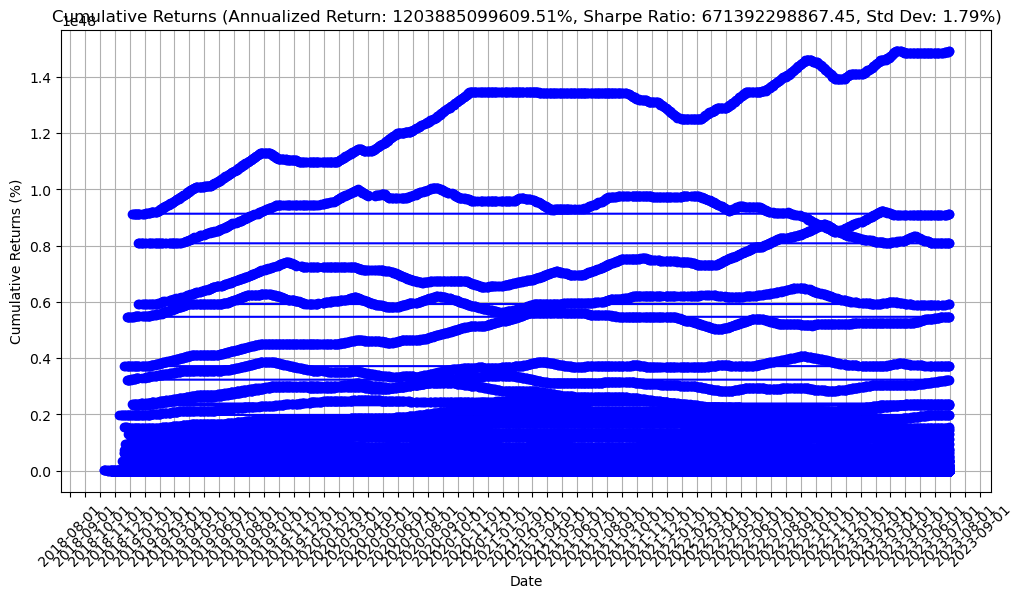

In [18]:
plot_cumulative_returns(trade_dates, portfolio_values)